In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import math
from random import randint
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.functional as F
from torchvision import models
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.ndimage.filters import convolve
from scipy import misc
import scipy.misc as sm
import cv2
from skimage.feature import canny
from IPython.display import HTML
from tqdm import tqdm_notebook
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/
device = 'cuda'
torch.cuda.manual_seed(7)
torch.manual_seed(7)
np.random.seed(7)
torch.cuda.empty_cache()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [0]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        assert kernel_size % 2 == 1, "Odd kernel size required"
        self.conv = nn.Conv2d(in_channels = 2, out_channels = 1, kernel_size = kernel_size, padding= int((kernel_size-1)/2))
        # batchnorm

    def forward(self, x):
        
        max_pool = self.agg_channel(x, "max")
        avg_pool = self.agg_channel(x, "avg")
        pool = torch.cat([max_pool, avg_pool], dim = 1)
        conv = self.conv(pool)
        # batchnorm ????????????????????????????????????????????
        conv = conv.repeat(1,x.size()[1],1,1)
        att = torch.sigmoid(conv)        
        return att

    def agg_channel(self, x, pool = "max"):
        b,c,h,w = x.size()
        x = x.view(b, c, h*w)
        x = x.permute(0,2,1)
        x = x.contiguous()

        if pool == "max":
            x = F.max_pool1d(x, c)
        elif pool == "avg":
            x = F.avg_pool1d(x,c)
        x = x.permute(0,2,1)
        x = x.contiguous()
        x = x.view(b,1,h,w)
        return x


In [3]:
x = torch.ones((8,512,256*256)).cuda()
x = x.permute(0,2,1)
x = x.contiguous()
x = F.max_pool1d(x,512).cuda()
x.size()

torch.Size([8, 65536, 1])

In [0]:
### Attention Blocks ###

class CBAM(nn.Module):

    def __init__(self, n_channels_in, reduction_ratio, kernel_size):
        super(CBAM, self).__init__()
        self.n_channels_in = n_channels_in
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size

        self.channel_attention = ChannelAttention(n_channels_in, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, f):
        chan_att = self.channel_attention(f)
        # print(chan_att.size())
        fp = chan_att * f
        # print(fp.size())
        spat_att = self.spatial_attention(fp)
        # print(spat_att.size())
        fpp = spat_att * fp
        # print(fpp.size())
        return fpp


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        assert kernel_size % 2 == 1, "Odd kernel size required"
        self.conv = nn.Conv2d(in_channels = 2, out_channels = 1, kernel_size = kernel_size, padding= int((kernel_size-1)/2))
        # batchnorm

    def forward(self, x):
        max_pool = self.agg_channel(x, "max")
        avg_pool = self.agg_channel(x, "avg")
        pool = torch.cat([max_pool, avg_pool], dim = 1)
        conv = self.conv(pool)
        # batchnorm ????????????????????????????????????????????
        conv = conv.repeat(1,x.size()[1],1,1)
        att = torch.sigmoid(conv)        
        return att

    def agg_channel(self, x, pool = "max"):
        b,c,h,w = x.size()
        x = x.view(b, c, h*w)
        x = x.permute(0,2,1)
        x = x.contiguous()

        if pool == "max":
            x = F.max_pool1d(x, c)
        elif pool == "avg":
            x = F.avg_pool1d(x,c)
        x = x.permute(0,2,1)
        x = x.contiguous()
        x = x.view(b,1,h,w)
        return x


class ChannelAttention(nn.Module):
    def __init__(self, n_channels_in, reduction_ratio):
        super(ChannelAttention, self).__init__()
        self.n_channels_in = n_channels_in
        self.reduction_ratio = reduction_ratio
        self.middle_layer_size = int(self.n_channels_in/ float(self.reduction_ratio))

        self.bottleneck = nn.Sequential(
            nn.Linear(self.n_channels_in, self.middle_layer_size),
            nn.ReLU(),
            nn.Linear(self.middle_layer_size, self.n_channels_in)
        )


    def forward(self, x):
        kernel = (x.size()[2], x.size()[3])
        avg_pool = F.avg_pool2d(x, kernel )
        max_pool = F.max_pool2d(x, kernel)

        
        avg_pool = avg_pool.view(avg_pool.size()[0], -1)
        max_pool = max_pool.view(max_pool.size()[0], -1)
        

        avg_pool_bck = self.bottleneck(avg_pool)
        max_pool_bck = self.bottleneck(max_pool)

        pool_sum = avg_pool_bck + max_pool_bck

        sig_pool = torch.sigmoid(pool_sum)
        sig_pool = sig_pool.unsqueeze(2).unsqueeze(3)

        out = sig_pool.repeat(1,1,kernel[0], kernel[1])
        return out

In [0]:
##### Coach Network #####

class coach_network(nn.Module):
  def __init__(self, drop_ratio = 0.5):
    super(coach_network,self).__init__()
    model = models.resnet18()
    self.layer1 = torch.nn.Sequential(*(list(model.children())[:2]))
    self.layer2 = torch.nn.Sequential(*(list(model.children())[4:-2]))
    self.drop_ratio = drop_ratio
    self.mu = nn.Conv2d(512,100,kernel_size = 1)
    self.std = nn.Conv2d(512,100,kernel_size = 1)
    self.pred = nn.Conv2d(100,1,kernel_size = 1)
    self.upsample = nn.Upsample(scale_factor=16, mode = 'nearest')
    self.sigmoid = nn.Sigmoid()


    for m in self.modules():
        if isinstance(m, nn.Conv2d) and m is not self.mu and m is not self.std:
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()


  def reparametrize(self,mu,logvar):
    std = logvar.mul_(0.5).exp_()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mu)


  def get_features(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    mu = self.mu(x)
    logvar = self.std(x)
    z = self.reparametrize(mu,logvar)
    d = self.pred(z)

    return d,mu,logvar

  
  def forward(self, x, alpha, use_coach = True):
    features = None
    mu = None
    logvar = None

    if not use_coach:
      size_ = x.size()
      features = Variable(torch.rand(size_[0], 1, int(size_[2]/16), int(size_[3]/16)).cuda())
    
    else:
      features,mu,logvar = self.get_features(x)

    size_ = features.size()
    features = features.view(size_[0], size_[1], size_[2]*size_[3])
    p,_ = features.topk(k = int(size_[2]*size_[3]*self.drop_ratio), dim = 2)
    partitions = p[:,:, -1]
    partitions = partitions.unsqueeze(2).expand(size_[0], size_[1], size_[2]*size_[3])
    mask = self.sigmoid(alpha*(features - partitions))


    mask = mask.view(size_)

    if not self.training:
        mask = (mask>0.5).float()

    mask = self.upsample(mask)

    return mask, mu, logvar


##### Inpainting Model #####

class residual_block_edge(nn.Module):
  def __init__(self,ngpu):
    super(residual_block_edge,self).__init__()
    self.ngpu = ngpu
    self.layer1 = nn.Sequential(nn.ReflectionPad2d(1), nn.utils.spectral_norm(nn.Conv2d(256,256,3,1,padding = 0)), nn.InstanceNorm2d(256), nn.ReLU(True))
    self.layer2 = nn.Sequential(nn.ReflectionPad2d(1), nn.utils.spectral_norm(nn.Conv2d(256,256,3,1,padding = 0)), nn.InstanceNorm2d(256))

  def forward(self,x):
    y = self.layer1(x)
    y = self.layer2(y)
    out = x + y
    return out



class residual_block_completion(nn.Module):
  def __init__(self,ngpu):
    super(residual_block_completion,self).__init__()
    self.ngpu = ngpu
    self.layer1 = nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(256,256,3,1,padding = 0), nn.InstanceNorm2d(256), nn.ReLU(True))
    self.layer2 = nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(256,256,3,1,padding = 0), nn.InstanceNorm2d(256))

  def forward(self,x):
    y = self.layer1(x)
    y = self.layer2(y)
    out = x + y
    return out




class generator1(torch.nn.Module):
  def __init__(self, ngpu):
    super(generator1,self).__init__()
    self.ngpu = ngpu
    self.c64 = nn.Sequential(nn.ReflectionPad2d(3),nn.utils.spectral_norm(nn.Conv2d(3,64,7,1, padding = 0)), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.cbam64 = CBAM(64,1,3)
    self.d128 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(64,128,4,2,padding = 1)), nn.InstanceNorm2d(128),nn.ReLU(True))
    self.cbam128 = CBAM(128,1,3)
    self.d256 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(128,256,4,2,padding =1)), nn.InstanceNorm2d(256),nn.ReLU(True))
    self.cbam256 = CBAM(256, 1, 3)
    self.r256 = residual_block_edge(ngpu)
    self.u128 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(256,128,4,2,padding = 1)), nn.InstanceNorm2d(128), nn.ReLU(True))
    self.u64 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(128,64,4,2,padding = 1)), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.out = nn.Sequential(nn.ReflectionPad2d(3), nn.utils.spectral_norm(nn.Conv2d(64,1,7,1, padding = 0)))

  def forward(self,x):
    x = self.c64(x)
    x = self.d128(x)
    x = self.d256(x)

    for i in range(8):
      x = self.r256(x)
    
    x = self.cbam256(x)
    x = self.u128(x)
    x = self.cbam128(x)
    x = self.u64(x)
    x = self.cbam64(x)
    x = self.out(x)
    out = torch.sigmoid(x)
    return out




class generator2(torch.nn.Module):
  def __init__(self,ngpu):
    super(generator2,self).__init__()
    self.ngpu = ngpu
    self.c64 = nn.Sequential(nn.ReflectionPad2d(3),nn.Conv2d(4,64,7,1,padding = 0), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.cbam64 = CBAM(64,1,7)
    self.d128 = nn.Sequential(nn.Conv2d(64,128,4,2,padding = 1),nn.InstanceNorm2d(128),nn.ReLU(True))
    self.cbam128 = CBAM(128,1,5)
    self.d256 = nn.Sequential(nn.Conv2d(128,256,4,2,padding = 1),nn.InstanceNorm2d(256),nn.ReLU(True))
    self.cbam256 = CBAM(256,1,3)
    self.r256 = residual_block_completion(ngpu)
    self.u128 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,padding = 1), nn.InstanceNorm2d(128), nn.ReLU(True))
    self.u64 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,padding = 1),nn.InstanceNorm2d(64), nn.ReLU(True))
    self.out = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(64,3,7,1,padding = 0))

  def forward(self,x):
    x = self.c64(x)
    x = self.d128(x)
    x = self.d256(x)

    for i in range(8):
      x = self.r256(x)

    x = self.cbam256(x)
    x = self.u128(x)
    x = self.cbam128(x)
    x = self.u64(x)
    x = self.cbam64(x)
    x = self.out(x)
    out = torch.tanh(x)
    return out

class discriminator(torch.nn.Module):
  def __init__(self,in_channels,ngpu):
    super(discriminator,self).__init__()
    self.ngpu = ngpu
    self.c1 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(in_channels,64,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c2 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(64,128,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c3 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(128,256,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c4 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(256,512,4,1,padding = 1)), nn.LeakyReLU(0.2))
    self.c5 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(512,1,4,1,padding = 1)))

  def forward(self,x):
    c1 = self.c1(x)
    c2 = self.c2(c1)
    c3 = self.c3(c2)
    c4 = self.c4(c3)
    c5 = self.c5(c4)
    out = torch.sigmoid(c5)
    return out, [c1, c2, c3, c4, c5]



class Vgg19(torch.nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        features = list(torchvision.models.vgg19(pretrained = True).features)[:31]
        self.features = nn.ModuleList(features).eval() 
        
    def forward(self, x):
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {1,6,11,20,29}:
                results.append(x)
        return results




def weights_init(m):
  classname = m.__class__.__name__
  if hasattr(m, 'weight') and (classname.find('Conv') != -1):
    if hasattr(m, 'bias') and m.bias is not None:
      nn.init.constant_(m.bias.data, 0.0)
    else:
      nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif classname.find('BatchNorm2d') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0.0)

In [0]:
def rgbtogray(image): #function that converts an rgb to grayscale image
  r,g,b = image[:,0,:,:], image[:,1,:,:], image[:,2,:,:]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  gray = gray.unsqueeze_(1)
  return gray

def regular_mask_grayscale(img,random_num):  #function that creates a square mask randomly that masks 25% of the image pixels
  k = 0
  b_size = img.size(0)
  mask_1 = torch.zeros((b_size,1,256,256))
  masked_image_1 = torch.zeros((b_size,1,256,256))
  for image in img:
    masked_image = image.squeeze_(0)*1
    rand = random_num
    mask = torch.zeros((256,256))
    for i in range(rand-10,rand+11):
      for j in range(rand-10,rand+11):
        masked_image[i][j] = 1.0
        mask[i][j] = 1.0
    masked_image = masked_image.unsqueeze_(0)
    mask = mask.unsqueeze_(0)
    mask_1[k,:,:,:] = mask
    masked_image_1[k,:,:,:] = masked_image
    k = k+1
  return masked_image_1,mask_1

def irregular_mask(img):  #function that randomly masks 30% of the image pixels
  mask = np.zeros((256,256))
  for i in range(140):
    for j in range(140):
      mask[i][j] = 1.0
  mask = mask.ravel()
  np.random.shuffle(mask)
  mask = mask.reshape((1,256,256))
  masked_img = img*1
  masked_img = np.maximum(masked_img,mask)
  return masked_img, mask

def gram_matrix(image):

  b,ch, h, w = image.size()
  f = image.view(b,ch, w * h)
  f_T = f.transpose(1,2)
  G = f.bmm(f_T) / (h * w * ch)

  return G

def canny_edge_detector(image):
  b_size = image.size(0)
  temp1 = torch.zeros((b_size,1,256,256))
  i = 0
  for images in image:
    temp = images.squeeze_(0)
    canny_edge = canny(temp.detach().cpu().numpy())
    canny_edge = torch.from_numpy(canny_edge).unsqueeze_(0)
    temp1[i,:,:,:] = canny_edge
    i = i+1
  return temp1

In [0]:
train_dataset = dset.VOCSegmentation('VOC_train1')
val_dataset = dset.VOCSegmentation('VOC_val1')

In [0]:
class voc_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset,erase_shape = [16,16], erase_count = 16):
    self.mean_bgr = np.array([0.4568, 0.4431, 0.4083])
    self.std_bgr = np.array([0.2676, 0.2641, 0.2680])
    self.dataset = dataset
    self.erase_shape = erase_shape
    self.erase_count = erase_count

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,index):
    image,mask = self.dataset.__getitem__(index)
    
    image = image.resize((256,256))
    image = np.array(image)

    mask = mask.resize((256,256))
    mask = np.array(mask)
    mask = mask.reshape((256,256,1))
    mask = np.repeat(mask, 3, axis = 2)
    mask = mask/255
    mask = mask > 0
    mask = mask.astype(np.float)
    mask = 1.0 - mask

 ## Flip the image with prob = 0.5 
    flip = torch.LongTensor(1).random_(0,2)[0]*2 - 1
    image = image[:, ::flip, :]
    mask = mask[:, ::flip, :]

## Rotate the image randomly
    choice = torch.LongTensor(1).random_(0,4)[0]
    angles = [0, 90, 180, 270]
    angle = angles[choice]
    center = tuple(np.array(image.shape)[:2]/2)
    rot_mat = None
    rot_mat = cv2.getRotationMatrix2D(center,angle,1)
    image = cv2.warpAffine(image, rot_mat, image.shape[:2], flags = cv2.INTER_LINEAR)
    mask = cv2.warpAffine(mask, rot_mat, mask.shape[:2], flags = cv2.INTER_LINEAR)
    if self.erase_count == 1:                             ### erase a patch in the center of image
        offset = (image.shape[0] - erase_shape[0])/2
        end = offset+erase_shape[0]
        mask[offset:end, offset:end, :] = 0
        
    else:   
        for c_ in range(self.erase_count):
            row = torch.LongTensor(1).random_(0, image.shape[0]-self.erase_shape[0]-1)[0]
            col = torch.LongTensor(1).random_(0, image.shape[1]-self.erase_shape[1]-1)[0]
            
            mask[row:row+self.erase_shape[0], col:col+self.erase_shape[1], :] = 0

    input_, mask, target = self.transform(image,mask)

    return input_, mask, target

  def transform(self, image, mask):
    image = image/255
    image = image.astype(np.float64)
    image -= self.mean_bgr
            
    input_ = image.copy()                        
    
    image[:,:,0] /= 3*self.std_bgr[0]
    image[:,:,1] /= 3*self.std_bgr[1]
    image[:,:,2] /= 3*self.std_bgr[2]

    index_ = image > 1
    image[index_] = 1
    index_ = image < -1
    image[index_] = -1
    image = image.transpose(2, 0, 1)
    image = torch.from_numpy(image.copy()).float()
    
    input_ = input_.transpose(2, 0, 1)
    input_ = torch.from_numpy(input_.copy()).float()                        
    
    mask = mask.transpose(2, 0, 1)
    mask = torch.from_numpy(mask.copy())                        

    return input_, mask, image

In [0]:
erase_shape = [16,16]
erase_count = 16
mean_bgr = np.array([0.4568, 0.4431, 0.4083])
std_bgr = np.array([0.2676, 0.2641, 0.2680])

train_loader = torch.utils.data.DataLoader(voc_dataset(dataset = train_dataset, erase_shape = erase_shape, erase_count = erase_count), batch_size = 1, shuffle = True, num_workers = 1)


val_loader = torch.utils.data.DataLoader(voc_dataset(dataset = val_dataset, erase_shape = erase_shape, erase_count = erase_count),batch_size = 1, num_workers = 1, shuffle = False)

In [0]:
coach_net = coach_network(drop_ratio = 0.75).cuda()

edge_generator = generator1(1).to(device)
inpaint_generator = generator2(1).to(device)
edge_discriminator = discriminator(2,1).to(device)
feature_matching_discriminator = discriminator(1,1).to(device)
inpaint_discriminator = discriminator(4,1).to(device)
vgg19 = Vgg19().to(device)


use_coach = True
coach_optimizer = None
inpainting_optimizer = None
best_loss = 1e5
train_loss = []
val_loss = []
coach_loss = []
rec_weight = 0.99

G1_losses = []
D1_losses = []
G2_losses = []
D2_losses = []
iters = 0
lr1 = 0.0001
beta1 = 0
beta2 = 0.9
criterion = nn.BCELoss()
l1criterion = nn.L1Loss()

edge_g_opt = optim.Adam(edge_generator.parameters(), lr=lr1, betas = (beta1, beta2))
edge_d_opt = optim.Adam(edge_discriminator.parameters(), lr=lr1/10, betas=(beta1, beta2))
inpaint_d_opt = optim.Adam(inpaint_discriminator.parameters(), lr=lr1/10, betas=(beta1, beta2))
inpaint_g_opt = optim.Adam(inpaint_generator.parameters(), lr=lr1, betas=(beta1, beta2))

In [0]:
def train_inpainting(epoch, edge_generator, inpainting_generator, edge_discriminator, inpainting_discriminator, feature_matching_discriminator, vgg19, edge_g_opt, edge_d_opt, inpaint_g_opt, inpaint_d_opt, coach = None, use_coach_masks = False):
  inpainting_generator.train()
  edge_generator.train()
  inpainting_discriminator.train()
  edge_discriminator.train()
  
  if coach is not None:
    coach.eval()

  for batch_idx, (inputs_, masks, targets) in enumerate(train_loader):
    if batch_idx < 175:
      edge_g_opt.zero_grad()
      inpaint_g_opt.zero_grad()
      edge_d_opt.zero_grad()
      inpaint_d_opt.zero_grad()

      inputs_, mask, targets = Variable(inputs_.to(device)), Variable(masks.to(device)), Variable(targets.to(device))

      b_size = inputs_.size(0)
      real_cpu = inputs_

      if coach is not None:
        mask, _, _ = coach.forward(inputs_,alpha = 1.0, use_coach = use_coach_masks)

      real_label = torch.full((b_size,1,30,30),1,device = device)  #label of ones
      fake_label = torch.full((b_size,1,30,30),0,device = device)  #label of zeros
  
      I_gray = rgbtogray(real_cpu).to(device)  #converting input image into grayscale
      C_gt = canny_edge_detector(I_gray) #edge map of the input image
      C_gt = C_gt.type(torch.FloatTensor).to(device)
      C_gt_1 = C_gt
      I_gray_masked = I_gray*mask #masked grayscale input and mask
      I_gray_masked = I_gray_masked.type(torch.FloatTensor).to(device)
      C_gt_masked = canny_edge_detector(I_gray_masked)  #masked edge map
      C_gt_masked = C_gt_masked.type(torch.FloatTensor).to(device)
      edge_generator_input = torch.cat((I_gray_masked, C_gt_masked, mask),1)  #concatenating all the 3 inputs to form the final input to edge generator
      C_pred = edge_generator(edge_generator_input)  #predicted edge map by generator, detaching so that gradients dont flow into the generator

      true = torch.cat((C_gt,I_gray),1).to(device)
      fake = torch.cat((C_pred,I_gray),1).to(device)

      true_probability, [c1,c2,c3,c4,c5] = edge_discriminator(true)
      fake_probability, [d1,d2,d3,d4,d5] = edge_discriminator(fake.detach())

      true_loss = criterion(true_probability, real_label)
      true_loss.backward()
      fake_loss = criterion(fake_probability, fake_label)
      fake_loss.backward()
      D1_loss = true_loss + fake_loss
      D1_losses.append(D1_loss)
      edge_d_opt.step()
      
      """
      Updating the G1 network
      """
      edge_generator.train()
      edge_g_opt.zero_grad()

      C_pred = edge_generator(edge_generator_input)  

      true_1 = C_gt_1
      fake_1 = C_pred

      true_probability_1, [c1,c2,c3,c4,c5] = feature_matching_discriminator(true_1)
      fake_probability_1, [d1,d2,d3,d4,d5] = feature_matching_discriminator(fake_1)

      #true_loss = criterion(true_probability_1, real_label)
      #fake_loss = criterion(fake_probability_1, fake_label)
      #edge_discriminator_loss = -(true_loss + fake_loss)

      fake_loss_updated = criterion(fake_probability_1,real_label).to(device)

      lfm_1 = l1criterion(c1,d1)
      lfm_2 = l1criterion(c2,d2)
      lfm_3 = l1criterion(c3,d3)
      lfm_4 = l1criterion(c4,d4)
      lfm_5 = l1criterion(c5,d5)
      lfm = lfm_1 + lfm_2 + lfm_3 + lfm_4 + lfm_5

      edge_generator_loss = 2*lfm + fake_loss_updated

      edge_generator_loss.backward()
      edge_g_opt.step()
      G1_losses.append(edge_generator_loss)

      """
      Updating the D2 network
      """
      inpaint_discriminator.train()
      inpaint_d_opt.zero_grad()

      I_gt_masked = real_cpu*mask
      
      C_pred_1 = C_pred.detach().to(device)
      I_gt = real_cpu.detach().to(device)
      C_comp = (C_gt_masked + (torch.ones((b_size,1,256,256)).to(device)-mask) * C_pred_1).to(device)
      generator2_input = torch.cat((I_gt_masked,C_comp),1).to(device)
      I_pred = inpaint_generator(generator2_input).to(device)

      true_2 = torch.cat((I_gt,C_comp),1).to(device)
      fake_2 = torch.cat((I_pred,C_comp),1).to(device)

      true_probability_2, [c1,c2,c3,c4,c5] = inpaint_discriminator(true_2)
      fake_probability_2, [d1,d2,d3,d4,d5] = inpaint_discriminator(fake_2.detach())

      true_loss_1 = criterion(true_probability_2,real_label).to(device)
      true_loss_1.backward()
      fake_loss_1 = criterion(fake_probability_2,fake_label).to(device)
      fake_loss_1.backward()
      D2_loss = (true_loss_1 + fake_loss_1).to(device)
      inpaint_d_opt.step()
      D2_losses.append(D2_loss)

      """
      Updating the G2 network
      """
      inpaint_generator.train()
      inpaint_g_opt.zero_grad()

      #L1 loss
      I_pred_1 = inpaint_generator(generator2_input).to(device)
      inpaint_generator_loss = (1 * l1criterion(I_pred_1, I_gt)).to(device)
      

      #Adversarial Loss
      true_3 = torch.cat((I_gt,C_comp),1).to(device)
      fake_3 = torch.cat((I_pred_1,C_comp),1).to(device)

      true_probability_3, [c1,c2,c3,c4,c5] = inpaint_discriminator(true_3)
      fake_probability_3, [d1,d2,d3,d4,d5] = inpaint_discriminator(fake_3)

      #true_loss_2 = criterion(true_probability_3,real_label).to(device)
      #fake_loss_2 = criterion(fake_probability_3,fake_label).to(device)
      
      fake_loss_updated = criterion(fake_probability_3,real_label).to(device)
      #inpaint_discriminator_loss = - (true_loss_2 + fake_loss_2)
      
      inpaint_generator_loss = inpaint_generator_loss + 0.1 * fake_loss_updated

      
      #Perceptual Loss
      [c1,c2,c3,c4,c5] = vgg19(I_pred_1)
      [d1,d2,d3,d4,d5] = vgg19(I_gt)

      lp_1 = l1criterion(c1,d1).to(device)
      lp_2 = l1criterion(c2,d2).to(device)
      lp_3 = l1criterion(c3,d3).to(device)
      lp_4 = l1criterion(c4,d4).to(device)
      lp_5 = l1criterion(c5,d5).to(device)

      lp_loss = lp_1 + lp_2 + lp_3 + lp_4 + lp_5
      lp_loss = lp_loss/50

      inpaint_generator_loss = inpaint_generator_loss + lp_loss


      #Style Loss
      ls_1 = l1criterion(gram_matrix(c1),gram_matrix(d1)).to(device)
      ls_2 = l1criterion(gram_matrix(c2),gram_matrix(d2)).to(device)
      ls_3 = l1criterion(gram_matrix(c3),gram_matrix(d3)).to(device)
      ls_4 = l1criterion(gram_matrix(c4),gram_matrix(d4)).to(device)
      ls_5 = l1criterion(gram_matrix(c5),gram_matrix(d5)).to(device)
      
      ls_loss = ls_1 + ls_2 + ls_3 + ls_4 + ls_5
      ls_loss = 250 * ls_loss

      inpaint_generator_loss = inpaint_generator_loss + ls_loss

      inpaint_generator_loss.backward()
      inpaint_g_opt.step()
      G2_losses.append(inpaint_generator_loss)

      print('[%d/%d]\t [%d/51]\t G2_loss: %.4f\t' % (epoch,epochs[iter_],batch_idx, inpaint_generator_loss))


def train_coach(epoch, inpaint_generator, edge_generator, coach_net, coach_optimizer):
  coach_net.train()
  inpaint_generator.eval()
  edge_generator.eval()
  coach_loss.append(0)

  for batch_idx, (inputs_, masks, targets) in enumerate(train_loader):
    if batch_idx < 175:
      coach_optimizer.zero_grad()
      inputs_, targets = Variable(inputs_.to(device)), Variable(targets.to(device))

      masks, mu, logvar = coach_net.forward(inputs_, alpha = 1)
      b_size = inputs_.size(0)

      test_cpu = inputs_
      I_gray = rgbtogray(test_cpu).cuda()
      I_gray_masked = masks*I_gray
      I_gray_masked = I_gray_masked.cuda()

      I_gt_masked = test_cpu*masks
      I_gt_masked = I_gt_masked.cuda()
      C_gt_masked = canny_edge_detector(I_gray_masked).cuda()
      edge_generator_input = torch.cat((I_gray_masked, C_gt_masked, masks),1)

      C_pred = edge_generator(edge_generator_input) ### Output after first generator

      C_comp = (C_gt_masked + (torch.ones((b_size,1,256,256)).to(device)-masks) * C_pred).to(device)
      generator2_input = torch.cat((I_gt_masked,C_comp),1).to(device)
      
      I_pred = inpaint_generator(generator2_input).to(device)
      
      outputs = I_pred
      
      mse_loss = (outputs - targets)**2
      mse_loss = -1*F.threshold(-1*mse_loss, -2, -2)
      loss_rec = torch.sum(mse_loss*(1 - masks))/torch.sum(1 - masks)

      mu = mu.mean(dim = 2).mean(dim = 2)
      logvar = logvar.mean(dim = 2).mean(dim = 2)

      KLD = 0 
      try:
        KLD = -0.5*torch.sum(1+logvar - mu**2 - logvar.exp())
      except:
        KLD = 0

      total_loss = 1 - loss_rec + 1e-6*KLD

      total_loss.backward()
      coach_optimizer.step()

      coach_loss[-1] = coach_loss[-1] + total_loss.data
      print('Coach (loss = %.4f)' % (coach_loss[-1]/(batch_idx+1)))
  coach_loss[-1] = coach_loss[-1]/len(train_loader)


def val_inpainting(iter_, epoch, inpaint_generator, edge_generator, inpaint_discriminator, edge_discriminator, coach = None, use_coach_masks = False):
  global best_loss
  inpaint_generator.eval()
  edge_generator.eval()

  if coach is not None:
    coach.eval()
  
  val_loss.append(0)
  for batch_idx, (inputs_, masks, targets) in enumerate(val_loader):
    if batch_idx < 175:
      inputs_, masks, targets = Variable(inputs_.cuda()), Variable(masks.cuda().float()), Variable(targets.cuda())

      if coach is not None:
        masks, _, _ = coach.forward(inputs_, alpha = 100, use_coach = use_coach_masks)

      b_size = inputs_.size(0)

      test_cpu = inputs_
      I_gray = rgbtogray(test_cpu).cuda()
      I_gray_masked = masks*I_gray
      I_gray_masked = I_gray_masked.cuda()

      I_gt_masked = test_cpu*masks
      I_gt_masked = I_gt_masked.cuda()
      C_gt_masked = canny_edge_detector(I_gray_masked).cuda()
      edge_generator_input = torch.cat((I_gray_masked, C_gt_masked, masks),1)

      C_pred = edge_generator(edge_generator_input) ### Output after first generator

      C_comp = (C_gt_masked + (torch.ones((b_size,1,256,256)).to(device)-masks) * C_pred).to(device)
      generator2_input = torch.cat((I_gt_masked,C_comp),1).to(device)
      
      I_pred = inpaint_generator(generator2_input).to(device)

      outputs_1 = I_pred
      mse_loss = (targets - outputs_1)**2
      mse_loss = (-1*F.threshold(-1*mse_loss, -2, -2))
      loss_rec = (torch.sum(mse_loss * (1 - masks))/torch.sum(1 - masks))

      total_loss = rec_weight*loss_rec

      val_loss[-1] = (val_loss[-1] + total_loss.data)
      print('Val (loss= %.4f)' % (val_loss[-1]/(batch_idx+1)))

  val_loss[-1] = (val_loss[-1]/len(val_loader))

  if best_loss > val_loss[-1]:
    best_loss = val_loss[-1]
    print('Saving...')
    state = {'inpaint_generator' : inpaint_generator, 'edge_generator' : edge_generator, 'inpaint_discriminator' : inpaint_discriminator, 'edge_discriminator' : edge_discriminator, 'coach' : coach}

    torch.save(state, 'edgeconnectupsamplingbmvc2018' + str(iter_) + '.ckpt.t7')

In [0]:
use_coach_masks = False
epochs = []
lrs = []

if use_coach:
    epochs = [15, 10, 30, 30, 30, 30]
    lrs = [[1e-1, 1e-2, 1e-3, 1e-4],
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5],
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5]]
else:
    epochs = [100]
    lrs = [[1e-1, 1e-2, 1e-3, 1e-4]]

In [0]:
for iter_ in range(2):
    best_loss = 1e5    
    
    if use_coach and iter_ > 0:
        use_coach_masks = True
        
        optimizer_coach = optim.Adam(coach_net.parameters(), lr=1e-5)
        
        for epoch in range(epochs[iter_]):
            train_coach(epoch, inpaint_generator = inpaint_generator, edge_generator = edge_generator, coach_net=coach_net, coach_optimizer=optimizer_coach)
    
    for epoch in range(epochs[iter_]):   
        train_inpainting(epoch, edge_generator = edge_generator, inpainting_generator = inpaint_generator, edge_discriminator = edge_discriminator, inpainting_discriminator = inpaint_discriminator, feature_matching_discriminator = feature_matching_discriminator, vgg19 = vgg19, edge_g_opt = edge_g_opt, edge_d_opt = edge_d_opt, inpaint_g_opt = inpaint_g_opt, inpaint_d_opt = inpaint_d_opt, coach=coach_net, use_coach_masks=use_coach_masks)
        val_inpainting(iter_, epoch, inpaint_generator = inpaint_generator, edge_generator = edge_generator, inpaint_discriminator = inpaint_discriminator, edge_discriminator = edge_discriminator, coach=coach_net, use_coach_masks=use_coach_masks)
        print('Epochs: %d/%d' % (epoch, epochs[iter_]))

[0/15]	 [0/51]	 G2_loss: 0.7430	
[0/15]	 [1/51]	 G2_loss: 0.7231	
[0/15]	 [2/51]	 G2_loss: 0.8985	


In [0]:
real_cpu = next(iter(val_loader))
input_ = real_cpu[0].cuda()
masks = real_cpu[1].cuda()
targets = real_cpu[2].cuda()

In [0]:
checkpoints = torch.load('edgeconnectupsamplingbmvc20180.ckpt.t7')
coach_net = checkpoints['coach']
inpaint_generator = checkpoints['inpaint_generator']
edge_generator = checkpoints['edge_generator']

In [0]:
test_cpu = input_
b_size = input_.size(0)

mask = torch.ones((b_size,256,256,3)).cuda()

for c_ in range(16):
    row = torch.LongTensor(1).random_(0, 256-16-1)[0]
    col = torch.LongTensor(1).random_(0, 256-16-1)[0]
    
    mask[:,row:row+16, col:col+16, :] = 0

masks = mask.reshape(b_size,3,256,256)
mask = torch.zeros((b_size,1,256,256)).cuda()
mask[:,0,:,:] = masks[:,0,:,:]

I_gray = rgbtogray(test_cpu).cuda()
I_gray_masked = mask*I_gray
I_gray_masked = I_gray_masked.cuda()

I_gt_masked = test_cpu*mask
I_gt_masked = I_gt_masked.cuda()
C_gt_masked = canny_edge_detector(I_gray_masked).cuda()
edge_generator_input = torch.cat((I_gray_masked, C_gt_masked, mask),1)

C_pred = edge_generator(edge_generator_input) ### Output after first generator

C_comp = (C_gt_masked + (torch.ones((b_size,1,256,256)).to(device)-mask) * C_pred).to(device)
I_gt_masked = I_gt_masked.type(torch.FloatTensor)
C_comp = C_comp.type(torch.FloatTensor)
generator2_input = torch.cat((I_gt_masked,C_comp),1).to(device)

I_pred = inpaint_generator(generator2_input).to(device)

outputs_1 = I_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


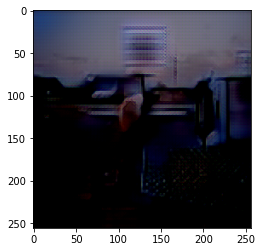

In [25]:
grid_img = torchvision.utils.make_grid(outputs_1.detach().cpu(), nrow = 4)
plt.imshow(grid_img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


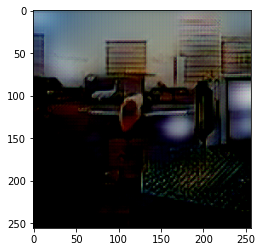

In [22]:
grid_img = torchvision.utils.make_grid(outputs_1.detach().cpu(), nrow = 4)
plt.imshow(grid_img.permute(1,2,0))